In [1]:
%%javascript
utils.load_extension('collapsible_headings/main')
utils.load_extension('hide_input/main')
utils.load_extension('autosavetime/main')
utils.load_extension('execute_time/ExecuteTime')
utils.load_extension('code_prettify/code_prettify')
utils.load_extension('scroll_down/main')
utils.load_extension('jupyter-js-widgets/extension')

<IPython.core.display.Javascript object>

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Ignacio Oguiza - email: oguiza@gmail.com

## A fastai/Pytorch implementation of MixMatch (Semi-supervised learning - SSL)

Berthelot, D., Carlini, N., Goodfellow, I., Papernot, N., Oliver, A., & Raffel, C. (2019). **Mixmatch: A holistic approach to semi-supervised learning.** arXiv preprint arXiv:1905.02249. [paper](https://arxiv.org/pdf/1905.02249)

I've created this notebook to show you how you can use MixMatch (a state-of-the-art semi-supervised learning technique) to leverage your unlabeled data.
MixMatch works amazingly well in those cases where you have a relatively small amount of labeled data, but have access to unlabeled data.

To build this notebook I've used fastai's excellent library, as well as an awesome [repo/notebook](https://github.com/noachr/MixMatch-fastai/blob/master/MixMatch%20Blog.ipynb) created by [Noah Rubinstein](https://github.com/noachr). Noah's notebook is a fantastic resource, the one I've seen to understand how MixMatch works. I highly recommend it!

My main contributions in this notebook have been to:
1. Simplify the code
2. Make it easy to use

## Import libraries

In [1]:
import fastai
from fastai.vision import *
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")
print(fastai.__version__)
print(torch.__version__)

1.0.58
1.3.0


## Prepare data

In [2]:
train_size = 500
seed = 1234
bs = 128
path = untar_data(URLs.CIFAR)
tfms = get_transforms()

### Prepare simulated labeled/ unlabeled

☣️ In this notebook we'll simulate we have 500 labeled samples and 49500 unlabeled samples to train (the original CIFAR10 contains 50k labeled examples). To do that we'll use some random, stratified indices.

The validation set will be the original one with 10k samples. You can skip this section when using your own data.

In [3]:
def random_strat_splitter(y, train_size:int=1, seed:int=1):
    from sklearn.model_selection import StratifiedShuffleSplit
    sss = StratifiedShuffleSplit(n_splits=1, train_size=train_size, random_state=seed)
    idx = list(sss.split(np.arange(len(y)), y))[0]
    return idx[0],idx[1]

In [4]:
y_train = ImageList.from_folder(path / 'train').split_none().label_from_folder().y.items # 50k
y_valid = ImageList.from_folder(path / 'test').split_none().label_from_folder().y.items  # 10k
l_idx, u_idx = random_strat_splitter(y_train, train_size=train_size, seed=seed)  # train_size, 50k - train_size
valid_idx, _ = random_strat_splitter(y_valid, train_size=train_size, seed=seed)  # 10k

### Prepare labeled databunch and list of unlabeled samples

1. Prepare your **labeled databunch** as you would normally do *.

(*) [l_idx] is used to select a subsample of the original train dataset. You don't need this when using your own data.

In [5]:
data = (ItemLists('.',
                  ImageList.from_folder(path / 'train')[l_idx],  # labeled train (in this case a subset of the original)
                  ImageList.from_folder(path / 'test'))          # labeled valid
        .label_from_folder()
        .transform(tfms)
        .databunch(bs=bs, val_bs=bs * 2)
        .normalize(cifar_stats))
print(data, '\n')

ImageDataBunch;

Train: LabelList (500 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
deer,bird,truck,cat,deer
Path: /home/oguizadl/.fastai/data/cifar10/train;

Valid: LabelList (10000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
ship,ship,ship,ship,ship
Path: /home/oguizadl/.fastai/data/cifar10/test;

Test: None 



2. Now you need to create an **unlabeled ItemList** of the same type as the one used for labeled samples (in this case an ImageList, but it could be any type of ItemList). It includes all unlabeled samples you want to use *.


(*) [u_idx] is used to select a subsample of the original train dataset. You don't need this when using your own data.

In [6]:
# unlabeled list
ulist = ImageList.from_folder(path / 'train')[u_idx]
print(ulist, '\n')

ImageList (49500 items)
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
Path: /home/oguizadl/.fastai/data/cifar10/train 



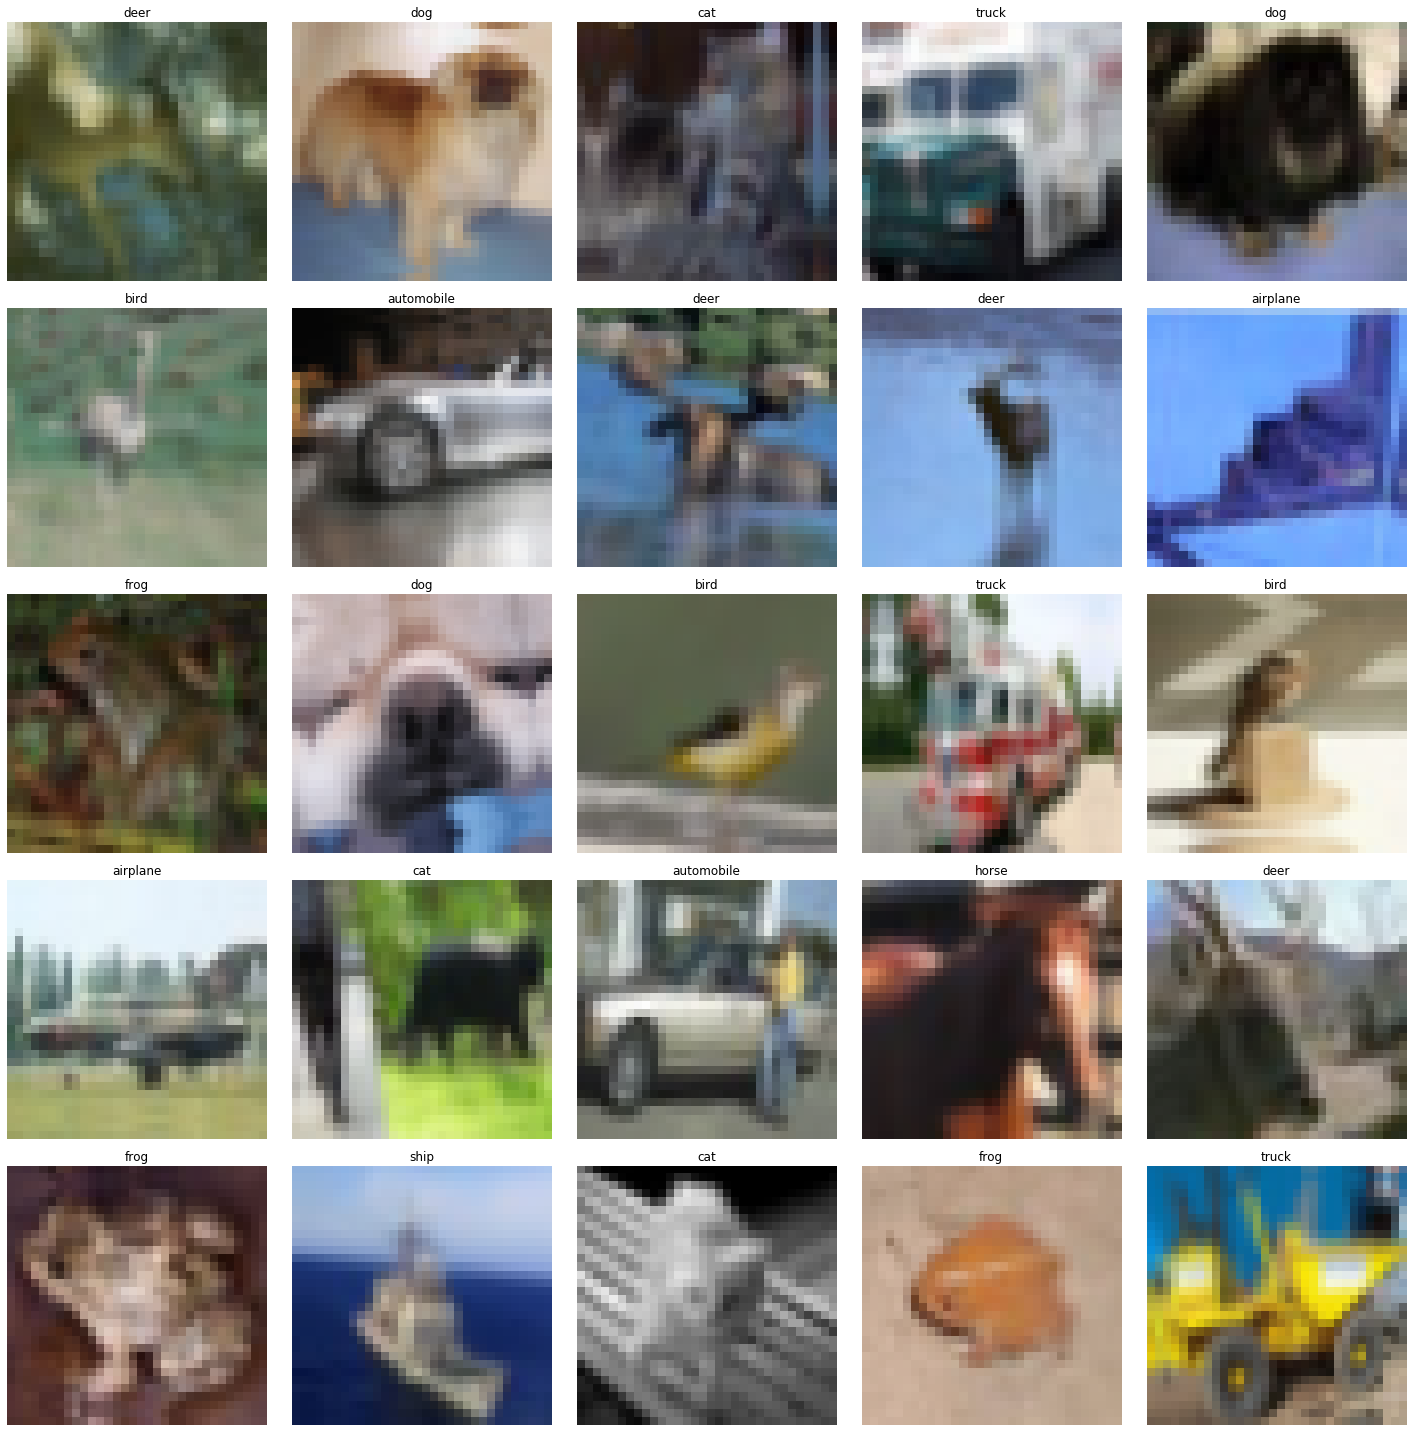

In [7]:
data.show_batch()

## MixMatch code

In [8]:
from numbers import Integral

class MultiTfmLabelList(LabelList):
    def __init__(self, x:ItemList, y:ItemList, tfms:TfmList=None, tfm_y:bool=False, K=2, **kwargs):
        "K: number of transformed samples generated per item"
        self.x,self.y,self.tfm_y,self.K = x,y,tfm_y,K
        self.y.x = x
        self.item=None
        self.transform(tfms, **kwargs)
        
    def __getitem__(self,idxs:Union[int, np.ndarray])->'LabelList':
        "return a single (x, y) if `idxs` is an integer or a new `LabelList` object if `idxs` is a range."
        idxs = try_int(idxs)
        if isinstance(idxs, Integral):
            if self.item is None: x,y = self.x[idxs],self.y[idxs]
            else:                 x,y = self.item   ,0
            if self.tfms or self.tfmargs:
                x = [x.apply_tfms(self.tfms, **self.tfmargs) for _ in range(self.K)]
            if hasattr(self, 'tfms_y') and self.tfm_y and self.item is None:
                y = y.apply_tfms(self.tfms_y, **{**self.tfmargs_y, 'do_resolve':False})
            if y is None: y=0
            return x,y
        else: return self.new(self.x[idxs], self.y[idxs])

def MultiCollate(batch):
    batch = to_data(batch)
    if isinstance(batch[0][0],list): batch = [[torch.stack(s[0]),s[1]] for s in batch]
    return torch.utils.data.dataloader.default_collate(batch)

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def mixmatch(learn: Learner, ulist: ItemList, num_workers:int=None, 
             K: int = 2, T: float = .5, α: float = .75, λ: float = 100) -> Learner:

    labeled_data = learn.data
    if num_workers is None: num_workers = 1
    labeled_data.train_dl.num_workers = num_workers
    bs = labeled_data.train_dl.batch_size
    tfms = [labeled_data.train_ds.tfms, labeled_data.valid_ds.tfms]
    
    ulist = ulist.split_none()
    ulist.train._label_list = partial(MultiTfmLabelList, K=K)
    train_ul = ulist.label_empty().train           # Train unlabeled Labelist
    valid_ll = learn.data.label_list.valid         # Valid labeled Labelist
    udata = (LabelLists('.', train_ul, valid_ll)
             .transform(tfms)
             .databunch(bs=min(bs, len(train_ul)),val_bs=min(bs * 2, len(valid_ll)),
                        num_workers=num_workers,dl_tfms=learn.data.dl_tfms,device=device,
                        collate_fn=MultiCollate)
             .normalize(learn.data.stats))
    learn.data = udata
    learn.callback_fns.append(partial(MixMatchCallback, labeled_data=labeled_data, T=T, α=α, λ=λ))
    return learn
    
Learner.mixmatch = mixmatch

In [10]:
def _mixup(x1, y1, x2, y2, α=.75):
    β = np.random.beta(α, α)
    β = max(β, 1 - β)
    x = β * x1 + (1 - β) * x2
    y = β * y1 + (1 - β) * y2
    return x, y

def sharpen(x, T=0.5):
    p_target = x**(1. / T)
    return p_target / p_target.sum(dim=1, keepdims=True)

In [11]:
def drop_cb_fn(learn, cb_name:str)->None:
    cbs = []
    for cb in learn.callback_fns:
        if isinstance(cb, functools.partial): cbn = cb.func.__name__
        else: cbn = cb.__name__
        if cbn != cb_name: cbs.append(cb)
    learn.callback_fns = cbs

In [12]:
class MatchMixLoss(Module):
    "Adapt the loss function `crit` to go with MatchMix."
    
    def __init__(self, crit=None, reduction='mean', λ=100):
        super().__init__()
        if crit is None: crit = nn.CrossEntropyLoss()
        if hasattr(crit, 'reduction'): 
            self.crit = crit
            self.old_red = crit.reduction
            setattr(self.crit, 'reduction', 'none')
        else: 
            self.crit = partial(crit, reduction='none')
            self.old_crit = crit
        self.reduction = reduction
        self.λ = λ
        
    def forward(self, preds, target, bs=None):
        
        if bs is None: return F.cross_entropy(preds, target)

        labeled_preds = torch.log_softmax(preds[:bs],dim=1)
        Lx = -(labeled_preds * target[:bs]).sum(dim=1).mean()
        self.Lx = Lx.item()

        unlabeled_preds = torch.softmax(preds[bs:],dim=1)
        Lu = F.mse_loss(unlabeled_preds,target[bs:])
        self.Lu = (Lu * self.λ).item()
        
        return Lx + Lu * self.λ
    
    def get_old(self):
        if hasattr(self, 'old_crit'):  return self.old_crit
        elif hasattr(self, 'old_red'): 
            setattr(self.crit, 'reduction', self.old_red)
            return self.crit

In [13]:
#export

class MixMatchCallback(LearnerCallback):
    _order = -20

    def __init__(self,
                 learn: Learner,
                 labeled_data: DataBunch,
                 T: float = .5,
                 K: int = 2,
                 α: float = .75,
                 λ: float = 100):
        super().__init__(learn)

        self.learn, self.T, self.K, self.α, self.λ = learn, T, K, α, λ
        self.labeled_dl = labeled_data.train_dl
        self.n_classes = labeled_data.c
        self.labeled_data = labeled_data
        

    def on_train_begin(self, n_epochs, **kwargs):
        self.learn.loss_func = MatchMixLoss(crit=self.learn.loss_func, λ=self.λ)
        self.ldliter = iter(self.labeled_dl)
        self.smoothLx, self.smoothLu = SmoothenValue(0.98), SmoothenValue(0.98)
        self.recorder.add_metric_names(["train_Lx", "train_Lu*λ"])
        self.it = 0
        print('labeled dataset     : {:13,} samples'.format(len(self.labeled_data.train_ds)))
        print('unlabeled dataset   : {:13,} samples'.format(len(self.learn.data.train_ds)))
        total_samples = n_epochs *len(self.learn.data.train_dl) *\
        self.learn.data.train_dl.batch_size * (self.K + 1)
        print('total train samples : {:13,} samples'.format(total_samples))

    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if not train: return
        try:
            Xx, Xy = next(self.ldliter)             # Xx already augmented
        except StopIteration:
            self.ldliter = iter(self.labeled_dl)
            Xx, Xy = next(self.ldliter)             # Xx already augmented

        # LABELED
        bs = len(Xx)
        pb = torch.eye(self.n_classes)[Xy].to(device)

        # UNLABELED
        shape = list(last_input.size()[2:])
        Ux = last_input.view([-1] + shape)           # Ux already augmented (K items)
        with torch.no_grad():
            Uy = sharpen(torch.softmax(torch.stack([
                self.learn.model(last_input[:, i])
                for i in range(last_input.shape[1])],dim=1),dim=2).mean(dim=1),T=self.T)
        qb = Uy.repeat(1, 2).view((-1, Uy.size(-1)))

        #MIX
        Wx = torch.cat((Xx, Ux), dim=0)
        Wy = torch.cat((pb, qb), dim=0)
        shuffle = torch.randperm(Wx.shape[0])
        mixed_input, mixed_target = _mixup(Wx, Wy, Wx[shuffle], Wy[shuffle], α=self.α)

        return {"last_input": mixed_input, "last_target": (mixed_target, bs)}

    def on_batch_end(self, train, **kwargs):
        if not train: return
        self.smoothLx.add_value(self.learn.loss_func.Lx)
        self.smoothLu.add_value(self.learn.loss_func.Lu)
        self.it += 1

    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics, [self.smoothLx.smooth, self.smoothLu.smooth])
    
    def on_train_end(self, **kwargs):
        """At the end of training, loss_func and data are returned to their original values, 
        and this calleback is removed"""
        self.learn.loss_func = self.learn.loss_func.get_old()
        self.learn.data = self.labeled_data
        drop_cb_fn(self.learn, 'MixMatchCallback')

## Experiments

### Supervised: 50k labeled samples

In [20]:
full_data = (ItemLists('.',
                  ImageList.from_folder(path / 'train'),         # labeled train
                  ImageList.from_folder(path / 'test'))          # labeled valid
        .label_from_folder()
        .transform(tfms)
        .databunch(bs=bs, val_bs=bs * 2)
        .normalize(cifar_stats))
print(full_data, '\n')

ImageDataBunch;

Train: LabelList (50000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
ship,ship,ship,ship,ship
Path: /home/oguizadl/.fastai/data/cifar10/train;

Valid: LabelList (10000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
ship,ship,ship,ship,ship
Path: /home/oguizadl/.fastai/data/cifar10/test;

Test: None 



In [21]:
model = models.WideResNet(num_groups=3, N=4, num_classes=10, k=2, start_nf=32)
learn = Learner(full_data, model, metrics=accuracy)
learn.fit_one_cycle(100)

epoch,train_loss,valid_loss,accuracy,time
0,1.413102,1.322538,0.517300,01:44
1,1.185652,1.235065,0.560000,00:45
2,1.077650,1.036387,0.626700,00:45
3,0.923953,0.888443,0.684000,00:45
4,0.833838,0.826511,0.710600,00:45
5,0.736363,0.733036,0.747200,00:45
6,0.671420,0.825750,0.728700,00:46
7,0.598679,0.681453,0.771800,00:45
8,0.546056,0.554246,0.811600,00:45
9,0.524312,0.631386,0.791700,00:45


### Baseline - Supervised: 500 labeled samples

In [18]:
print(data)

ImageDataBunch;

Train: LabelList (500 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
deer,bird,truck,cat,deer
Path: /home/oguizadl/.fastai/data/cifar10/train;

Valid: LabelList (10000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
ship,ship,ship,ship,ship
Path: /home/oguizadl/.fastai/data/cifar10/test;

Test: None


In [19]:
model = models.WideResNet(num_groups=3, N=4, num_classes=10, k=2, start_nf=32)
learn = Learner(data, model, metrics=accuracy)
learn.fit_one_cycle(100)

epoch,train_loss,valid_loss,accuracy,time
0,2.317151,2.290652,0.149500,00:10
1,2.290763,2.284799,0.169400,00:04
2,2.260745,2.277761,0.175200,00:04
3,2.233395,2.262488,0.193500,00:04
4,2.208789,2.239619,0.209100,00:04
5,2.183118,2.206290,0.234400,00:04
6,2.151777,2.167754,0.260100,00:04
7,2.122119,2.119564,0.273500,00:04
8,2.088179,2.066700,0.284400,00:04
9,2.049404,1.994711,0.298400,00:04


### Supervised: 500 labeled samples + Mixup

In [22]:
# mixup - alpha = .72 (as in MixMatch)
model = models.WideResNet(num_groups=3, N=4, num_classes=10, k=2, start_nf=32)
learn = Learner(data, model, metrics=accuracy).mixup(alpha=.75)
learn.fit_one_cycle(100)

epoch,train_loss,valid_loss,accuracy,time
0,2.333631,2.307531,0.135300,00:04
1,2.308702,2.284551,0.159800,00:04
2,2.286258,2.269721,0.173600,00:04
3,2.268240,2.248985,0.177600,00:04
4,2.249260,2.226807,0.204100,00:04
5,2.235694,2.196989,0.218800,00:04
6,2.218822,2.149207,0.222700,00:04
7,2.198883,2.118525,0.227700,00:04
8,2.177492,2.069287,0.253900,00:04
9,2.158753,2.020361,0.270300,00:04


In [14]:
# mixup - alpha = .5 (as in MixMatch's paper)
model = models.WideResNet(num_groups=3, N=4, num_classes=10, k=2, start_nf=32)
learn = Learner(data, model, metrics=accuracy).mixup(alpha=.5)
learn.fit_one_cycle(100)

epoch,train_loss,valid_loss,accuracy,time
0,2.306844,2.312384,0.117200,00:09
1,2.283394,2.282168,0.130400,00:04
2,2.262537,2.269323,0.144000,00:04
3,2.248402,2.249822,0.161400,00:04
4,2.233027,2.231457,0.174900,00:04
5,2.216703,2.215423,0.198000,00:04
6,2.201614,2.167142,0.253200,00:04
7,2.184015,2.137102,0.265300,00:04
8,2.162226,2.113269,0.273300,00:04
9,2.141590,2.045098,0.281900,00:04


### Semi-supervised: 500 labeled + 49500 unlabeled samples using MixMatch

In [143]:
model = models.WideResNet(num_groups=3, N=4, num_classes=10, k=2, start_nf=32)
learn = Learner(data, model, metrics=accuracy).mixmatch(ulist, α=.75, λ=75)

In [144]:
learn.fit_one_cycle(100)

labeled ds  :    500
unlabeled ds:  49500


epoch,train_loss,valid_loss,accuracy,train_Lx,train_Lu*λ,time
0,2.684314,2.892641,0.102800,2.186007,0.498305,03:09
1,2.018796,2.776649,0.140000,1.549589,0.469205,03:09
2,1.886331,2.621762,0.193400,1.299286,0.587042,03:09
3,1.711965,2.405672,0.270800,1.101404,0.610559,03:10
4,2.028985,1.715327,0.477000,1.157192,0.871791,03:10
5,1.918078,1.666925,0.498000,1.048883,0.869193,03:10
6,2.042164,1.700601,0.516100,1.089569,0.952594,03:10
7,2.086326,1.589027,0.523200,1.103491,0.982834,03:10
8,2.017304,1.538879,0.554200,1.068322,0.948981,03:09
9,1.939188,1.589867,0.556200,1.002264,0.936922,03:10


### Warning

You may sometimes get a warning like the one below. If training continues, don't worry about it.
However, your training may also get stopped. It seems to be a problem with Pytorch dataloader when using multiprocessing. If this is your case, you may need to modify the parameter num_workers in mixmatch and set it to 0. This however, will have a heavy impact on performance!

In [33]:
model = models.WideResNet(num_groups=3, N=4, num_classes=10, k=2, start_nf=32)
learn = Learner(data, model, metrics=accuracy).mixmatch(ulist, α=.75, λ=75, num_workers=None)
learn.fit_one_cycle(2)

labeled dataset     :           500 samples
unlabeled dataset   :        49,500 samples
total train samples :       296,448 samples


epoch,train_loss,valid_loss,accuracy,train_Lx,train_Lu*λ,time
0,2.086064,2.832476,0.169700,1.591187,0.494875,03:07
1,1.312561,2.682193,0.190800,0.875799,0.436760,03:06


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcee3de8c20>
Traceback (most recent call last):
  File "/home/oguizadl/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/oguizadl/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/oguizadl/anaconda3/envs/fastai-v1/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


In [ ]:
model = models.WideResNet(num_groups=3, N=4, num_classes=10, k=2, start_nf=32)
learn = Learner(data, model, metrics=accuracy).mixmatch(ulist, α=.75, λ=75, num_workers=0)
learn.fit_one_cycle(2)

## Conclusions

MixMatch is a state-of-the-art semi-supervised learning technique that works extremely well in those cases where you have a relatively small labeled dataset, and a larger unlabeled dataset.
In terms of accuracy, here's the comparison between the previous 4 options: 

1. Supervised training: 50k labeled samples
2. Supervised training: 500 labeled samples (1% of total)
3. Supervised training: 500 labeled samples with Mixup
4. Semi-supervised training: 500 labeled + 49500 unlabeled samples with MixMatch

<img src="./images/MixMatch_comparison_performance.jpg">

The training time however is the price you'll need to pay to use this technique. 
It takes 4.5 times longer to run mixmatch for 50k (500 labeled + 49.5k unlabeled) than 50k labeled. This seems to be in line with the time required by Google's original MixMatch code. The mention in their website it took them 20+ hours to run on a V100. 
This is the reason I've only run 100 epochs, and didn't try to replicate the results in the original paper. 
In the original MixMatch code, they run the equivalent to 450 epochs approx. I only have access to a single, preemptible GPU P100. It would have taken me more than 24h to run.

<img src="./images/MixMatch_time_comparison.jpg">

So you'll need to make a trade off, between time spend and accuracy. 

But I still think it's amazing you can get this level of performance with **just 1% of the labels!!**